<a href="https://colab.research.google.com/github/jtmonroe/FreeCodeCamp-MachineLearning/blob/main/fcc_book_recommendation_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [179]:
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In this challenge, you will create a book recommendation algorithm using K-Nearest Neighbors.

You will use the Book-Crossings dataset. This dataset contains 1.1 million ratings (scale of 1-10) of 270,000 books by 90,000 users.

After importing and cleaning the data, use NearestNeighbors from sklearn.neighbors to develop a model that shows books that are similar to a given book. The Nearest Neighbors algorithm measures the distance to determine the “closeness” of instances.

Create a function named get_recommends that takes a book title (from the dataset) as an argument and returns a list of 5 similar books with their distances from the book argument.

This code:

```python
get_recommends("The Queen of the Damned (Vampire Chronicles (Paperback))")
```
should return:

```python
[
  'The Queen of the Damned (Vampire Chronicles (Paperback))',
  [
    ['Catch 22', 0.793983519077301],
    ['The Witching Hour (Lives of the Mayfair Witches)', 0.7448656558990479],
    ['Interview with the Vampire', 0.7345068454742432],
    ['The Tale of the Body Thief (Vampire Chronicles (Paperback))', 0.5376338362693787],
    ['The Vampire Lestat (Vampire Chronicles, Book II)', 0.5178412199020386]
  ]
]
```
Notice that the data returned from get_recommends() is a list. The first element in the list is the book title passed into the function. The second element in the list is a list of five more lists. Each of the five lists contains a recommended book and the distance from the recommended book to the book passed into the function.

If you graph the dataset (optional), you will notice that most books are not rated frequently. To ensure statistical significance, remove from the dataset users with less than 200 ratings and books with less than 100 ratings.

The first three cells import libraries you may need and the data to use. The final cell is for testing. Write all your code in between those cells.



In [180]:
# get data files
# !wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip

# !unzip book-crossings.zip

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

In [181]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

We need to have a set of titles and authors which are regular because we are going to dedup by these fields

In [182]:
df_books["title"] = df_books.title.apply(lambda x: x.lower())
df_books["author"] = df_books.author[df_books.author.notna()].apply(lambda x: x.lower())

In [183]:
  print("====================== Books ======================")
  print(f"Shape: {df_books.shape}")
  print(df_books.head())
  print(f"Num Unique Authors: {df_books.author.unique().size}")
  print(f"Num Unique Books: {df_books.isbn.unique().size}")

  print("===================== Ratings =====================")
  print(f"Shape: {df_ratings.shape}")
  print(df_ratings.head())
  print(f"Num Unique Users: {df_ratings.user.unique().size}")
  print(f"Num Unique Books: {df_ratings.isbn.unique().size}")

====================== Books ======================
Shape: (271379, 3)
         isbn                                              title  \
0  0195153448                                classical mythology   
1  0002005018                                       clara callan   
2  0060973129                               decision in normandy   
3  0374157065  flu: the story of the great influenza pandemic...   
4  0393045218                             the mummies of urumchi   

                 author  
0    mark p. o. morford  
1  richard bruce wright  
2          carlo d'este  
3      gina bari kolata  
4       e. j. w. barber  
Num Unique Authors: 99360
Num Unique Books: 271379
===================== Ratings =====================
Shape: (1149780, 3)
     user        isbn  rating
0  276725  034545104X     0.0
1  276726  0155061224     5.0
2  276727  0446520802     0.0
3  276729  052165615X     3.0
4  276729  0521795028     6.0
Num Unique Users: 105283
Num Unique Books: 340556


In [184]:
# add your code here - consider creating a new cell for each section of code
df_ratings

,user,isbn,rating
0,276725,034545104X,0.0
1,276726,0155061224,5.0
2,276727,0446520802,0.0
3,276729,052165615X,3.0
4,276729,0521795028,6.0
...,...,...,...
1149775,276704,1563526298,9.0
1149776,276706,0679447156,0.0
1149777,276709,0515107662,10.0
1149778,276721,0590442449,10.0


In [185]:
df_books

,isbn,title,author
0,0195153448,classical mythology,mark p. o. morford
1,0002005018,clara callan,richard bruce wright
2,0060973129,decision in normandy,carlo d'este
3,0374157065,flu: the story of the great influenza pandemic...,gina bari kolata
4,0393045218,the mummies of urumchi,e. j. w. barber
...,...,...,...
271374,0440400988,there's a bat in bunk five,paula danziger
271375,0525447644,from one to one hundred,teri sloat
271376,006008667X,lily dale : the true story of the town that ta...,christine wicker
271377,0192126040,republic (world's classics),plato


In [186]:
def plot_rating_counts(sequence, ylabel, cuttoff):
  fig, ax = plt.subplots()
  counts = sequence.value_counts()
  counts[counts < 500].plot.hist(bins = 200, xlabel="# Reviews", ylabel=f"# {ylabel}", ax=ax)
  ax.axvline(cuttoff, ls="--", label="cutoff")
  ax.legend(loc="upper right")
  fig.show()

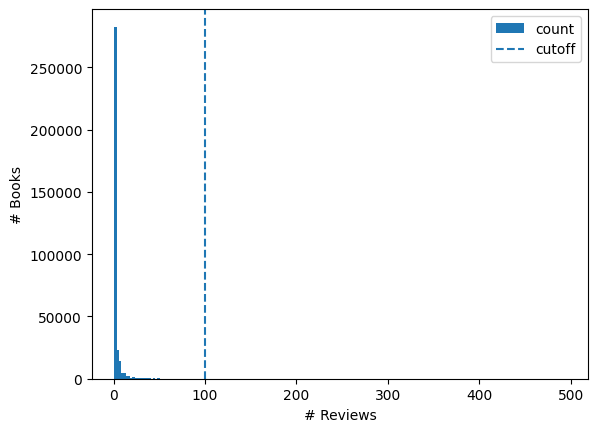

In [187]:
plot_rating_counts(df_ratings.isbn, "Books", 100)

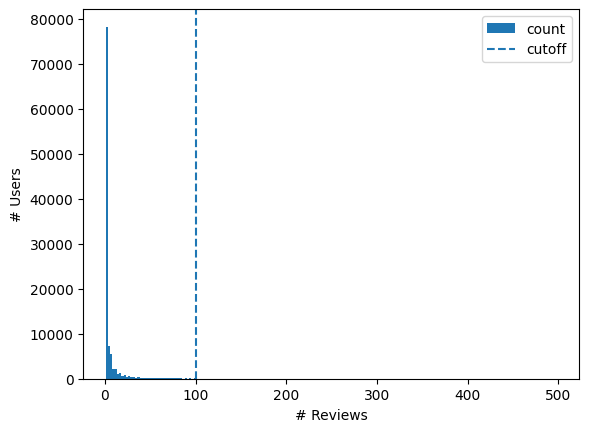

In [188]:
plot_rating_counts(df_ratings.user, "Users", 100)

1. Remove Duplicates
2. Plot Review counts by
  1. Book
  2. User
3. Remove insignificant
  1. Books with less than 100 Ratings
  2. Users with less than 200 Ratings

In [189]:
df_books = df_books.drop_duplicates(["title", "author"])
df_ratings = df_ratings[df_ratings.isbn.isin(df_books.isbn) ]

book_review_counts = df_ratings.pivot_table(values="user", index="isbn", aggfunc="count")
book_review_counts = book_review_counts[book_review_counts.user >= 100]
df_ratings = df_ratings[df_ratings.isbn.isin(book_review_counts.index)]

user_review_counts = df_ratings.pivot_table(values="isbn", index="user", aggfunc="count")
user_review_counts = user_review_counts[user_review_counts.isbn >= 200]
df_ratings = df_ratings[df_ratings.user.isin(user_review_counts.index)]

df_books = df_books[df_books.isbn.isin(df_ratings.isbn)]

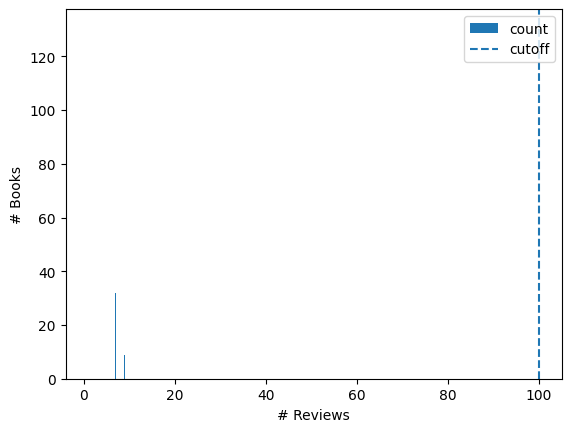

In [190]:
plot_rating_counts(df_ratings.isbn, "Books", 100)

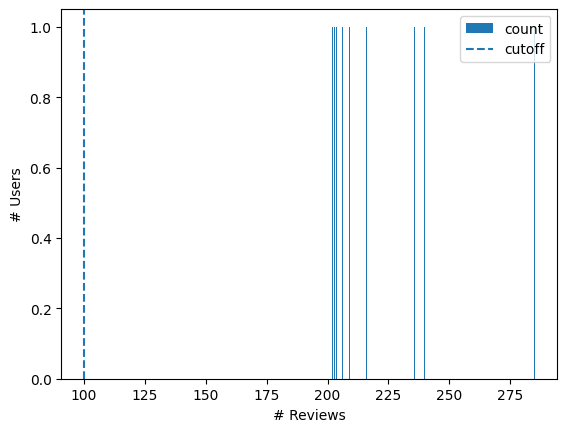

In [191]:
plot_rating_counts(df_ratings.user, "Users", 100)

In [192]:
  print("====================== Books ======================")
  print(f"Shape: {df_books.shape}")
  print(df_books.head())
  print(f"Num Unique Authors: {df_books.author.unique().size}")
  print(f"Num Unique Books: {df_books.isbn.unique().size}")

  print("===================== Ratings =====================")
  print(f"Shape: {df_ratings.shape}")
  print(df_ratings.head())
  print(f"Num Unique Users: {df_ratings.user.unique().size}")
  print(f"Num Unique Books: {df_ratings.isbn.unique().size}")

====================== Books ======================
Shape: (586, 3)
          isbn                                 title            author
18  0440234743                         the testament      john grisham
19  0452264464  beloved (plume contemporary fiction)     toni morrison
26  0971880107                           wild animus      rich shapero
27  0345402871                              airframe  michael crichton
28  0345417623                              timeline  michael crichton
Num Unique Authors: 270
Num Unique Books: 586
===================== Ratings =====================
Shape: (2534, 3)
        user        isbn  rating
45462  11676  002542730X     6.0
45516  11676  0060096195     0.0
45530  11676  006016848X     9.0
45537  11676  0060173289     0.0
45541  11676  0060175400    10.0
Num Unique Users: 10
Num Unique Books: 586


In [234]:
usable_table = df_books.merge(df_ratings, on="isbn").pivot(index="isbn", columns="user", values="rating").fillna(0.0)
model = NearestNeighbors()
model.fit(usable_table)
isbn = df_books.loc[df_books.title == "the testament"].isbn.iloc[0]
print(isbn)
len(model.kneighbors(usable_table.loc[[isbn], :], n_neighbors=5))

0440234743


2

In [ ]:
# function to return recommended books - this will be tested
def get_recommends(book = ""):
  isbn = df_books.loc[df_books.title == book.lower()].isbn.iloc[0]
  neighbors = model.kneighbors(usable_table.loc[[isbn], :])

  return recommended_books

In [ ]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
  for i in range(2):
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You haven't passed yet. Keep trying!")

test_book_recommendation()